In [1]:
# from numpy import*
from pylab import*
import matplotlib.pyplot as plt
from h5py import File
import pandas as pd
from slab.dsfit import*
# from slab import*
import json
import numpy as np
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from h5py import File
import os
from slab.dataanalysis import get_next_filename
import math
import scipy.special
from scipy.stats import poisson

C:\ProgramData\Miniconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Fit functions

In [2]:
def coherent_state(n, alpha):
    return np.exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

def gfromchi(chi,alpha,delta):
    return np.sqrt(chi*delta*(delta+alpha)/alpha)

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(x, *args):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0 
    p = args
#     print(len(p))
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y

def fitgausssum(xdata, ydata, fitparams=None, domain=None, showfit=False,
                showstartfit=False, label="", debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata, ydata, domain)
    else:
        fitdatax = xdata
        fitdatay = ydata
    
    if fitparams is None:
        fitparams = 0*ones(3*N+1)
        fitparams[0] = (fitdatay[0] + fitdatay[-1])/2.
        fitparams[1] = max(fitdatay) - min(fitdatay)
        fitparams[2] = fitdatax[np.argmax(fitdatay)]
        fitparams[3] = (max(fitdatax) - min(fitdatax))/10.
    
    if debug==True: 
        print(fitparams)
        
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, 
                    showstartfit=showstartfit, label=label)
    p1[3]=abs(p1[3])
    
    return p1

def fitgausssum_with_baseline(xdata, ydata, fitparams=None):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    fitdatax = xdata
    fitdatay = ydata
#     if fitparams is None:
#         fitparams = 0*ones(3*N+1)
#         fitparams[0] = (fitdatay[0]+fitdatay[-1])/2.
#         fitparams[1] = max(fitdatay)-min(fitdatay)
#         fitparams[2] = fitdatax[np.argmax(fitdatay)]
#         fitparams[3] = (max(fitdatax)-min(fitdatax))/10.
    
#     p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit,
#                     showstartfit=showstartfit, label=label)
#     bounds=(0, [3., 1., 0.5])
        
    popt, pcov = curve_fit(gaussfuncsum_with_baseline, fitdatax, fitdatay, p0=fitparams, bounds=(0, N))

    return popt, pcov

def fitamp(p1):
    fitamparray = []
    fitfreqarray = []
    n_peaks = int((len(p1)-1)/3)
    for i in range(n_peaks):
        fitamparray.append(p1[3*i+1])
        fitfreqarray.append(p1[3*i+2])
    return fitamparray , fitfreqarray

def fitcoherentstate(peak_val):
    xdata = np.arange(len(peak_val))
    ydata = peak_val
    popt, pcov = curve_fit(coherent_state, xdata, ydata)
    return popt[0], np.sqrt(pcov[0][0])

def expfunc2(x, p):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*np.exp**(-(x-p[1])/p[2])

def fitexp2(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

def expfunc_test(x, a, b, c):
    return b*np.exp(-(x-a)/c)

def expfunc_baseline(x, a, b, c):
    return a*np.exp(-x/b) + c

def decaysin_ramsey(x, a, b, c, d, e, f):
    """p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-p[5])/p[3])+p[4]"""
    return a*np.sin(2.*np.pi*b*x+c*np.pi/180.)*np.exp(-1.*(x-f)/d)+e

def gauss(x, mu, sigma, a):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def bimodal(x, mu1, sigma1, a1, mu2, sigma2, a2):
    return gauss(x, mu1, sigma1, a1) + gauss(x, mu2, sigma2, a2)

def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

def hist(filename=None, data=None, plot=True, ran=1.0):
    
    if data == None:
        with File(filename,'r') as a:
            ig = array(a['ig'])
            qg = array(a['qg'])
            ie = array(a['ie'])
            qe = array(a['qe'])
            a.close()
    else:
        ig = data[0]
        qg = data[1]
        ie = data[2]
        qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -arctan((ye-yg)/(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*cos(theta) - qg*sin(theta)
    qg_new = ig*sin(theta) + qg*cos(theta) 
    ie_new = ie*cos(theta) - qe*sin(theta)
    qe_new = ie*sin(theta) + qe*cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)

    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
    ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='upper right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
        popt, pcov = curve_fit(bimodal, xdata=binsg[:-1], ydata=ng, p0=None)
        mu_g = popt[0]
        axs[2].plot(binsg, bimodal(binsg, *popt), 'k--', linewidth=2 )
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
        popt, pcov = curve_fit(bimodal, xdata=binse[:-1], ydata=ne, p0=None)
        mu_e = popt[3]
        axs[2].plot(binse, bimodal(binse, *popt), 'k--', linewidth=2 )
#         axs[2].text(0.5*(mu_g + mu_e), 0.3*np.max(ne), "$\mu_{g}$ = %.4f \n $\mu_{e}$ = %.4f"%(mu_g, mu_e), fontsize=16)
        axs[2].set_xlabel('I(a.u.)')        
        axs[2].set_title('F = %.3f'%fid)
        fig.show()
        
    return fid, theta

def rot_data(i, q, hist_filename=None):
    
    fid, theta = hist(hist_filename, ran=0.1)
    print(fid, theta)
    """Rotate the IQ data"""
    i_new = i*cos(theta) - q*sin(theta)
    q_new = i*sin(theta) + q*cos(theta) 
    
    return (i_new, q_new)

def ramsfit(tR, n0, phi0, a):
    T2 = 120e-6
    dephase = 1/T2
    detune = 2*np.pi*1e6 
    chi = 2*np.pi*380e3
    kappa = 2*np.pi*(8.0517e9)/8800
    tau = []
    z = []
    res = []
    for i,t in enumerate(tR):
        tau.append((1-np.exp(-complex(kappa*tR[i], 2*chi*tR[i])))/complex(kappa, 2*chi))
        z.append(np.exp(complex(-dephase*tR[i] , phi0 - detune*tR[i] - 2*n0*chi*tau[i])))
        res.append(a*0.5*(1-np.imag(z[i])))
    return np.array(res)

def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

In [25]:
def alpha_awg_cal(cav_amp=1.0, cav_len=250):
    # takes input array of amps and length and converts them to output array of alphas,
    # using a calibration h5 file defined in the experiment config
    # pull calibration data from file, handling properly in case of multimode cavity
    cal_path = 'C:\_Lib\python\slab\experiments\qm_opx_mm\drive_calibration'

    fn_file = cal_path + '\\00000_2021_12_16_cavity_square_mode_2.h5'

    with File(fn_file, 'r') as f:
        omegas = np.array(f['omegas'])
        amps = np.array(f['amps'])

    # assume zero frequency at zero amplitude, used for interpolation function
    omegas = np.append(omegas, 0.0)
    amps = np.append(amps, 0.0)

    o_s = omegas
    a_s = amps

    # interpolate data, transfer_fn is a function that for each amp returns the corresponding omega
    transfer_fn = scipy.interpolate.interp1d(a_s, o_s)

    omega_desired = transfer_fn(cav_amp)
    alpha = omega_desired * cav_len

    """Returns alpha in the cavity"""
    return alpha

# Resonator spectroscopy

## Square

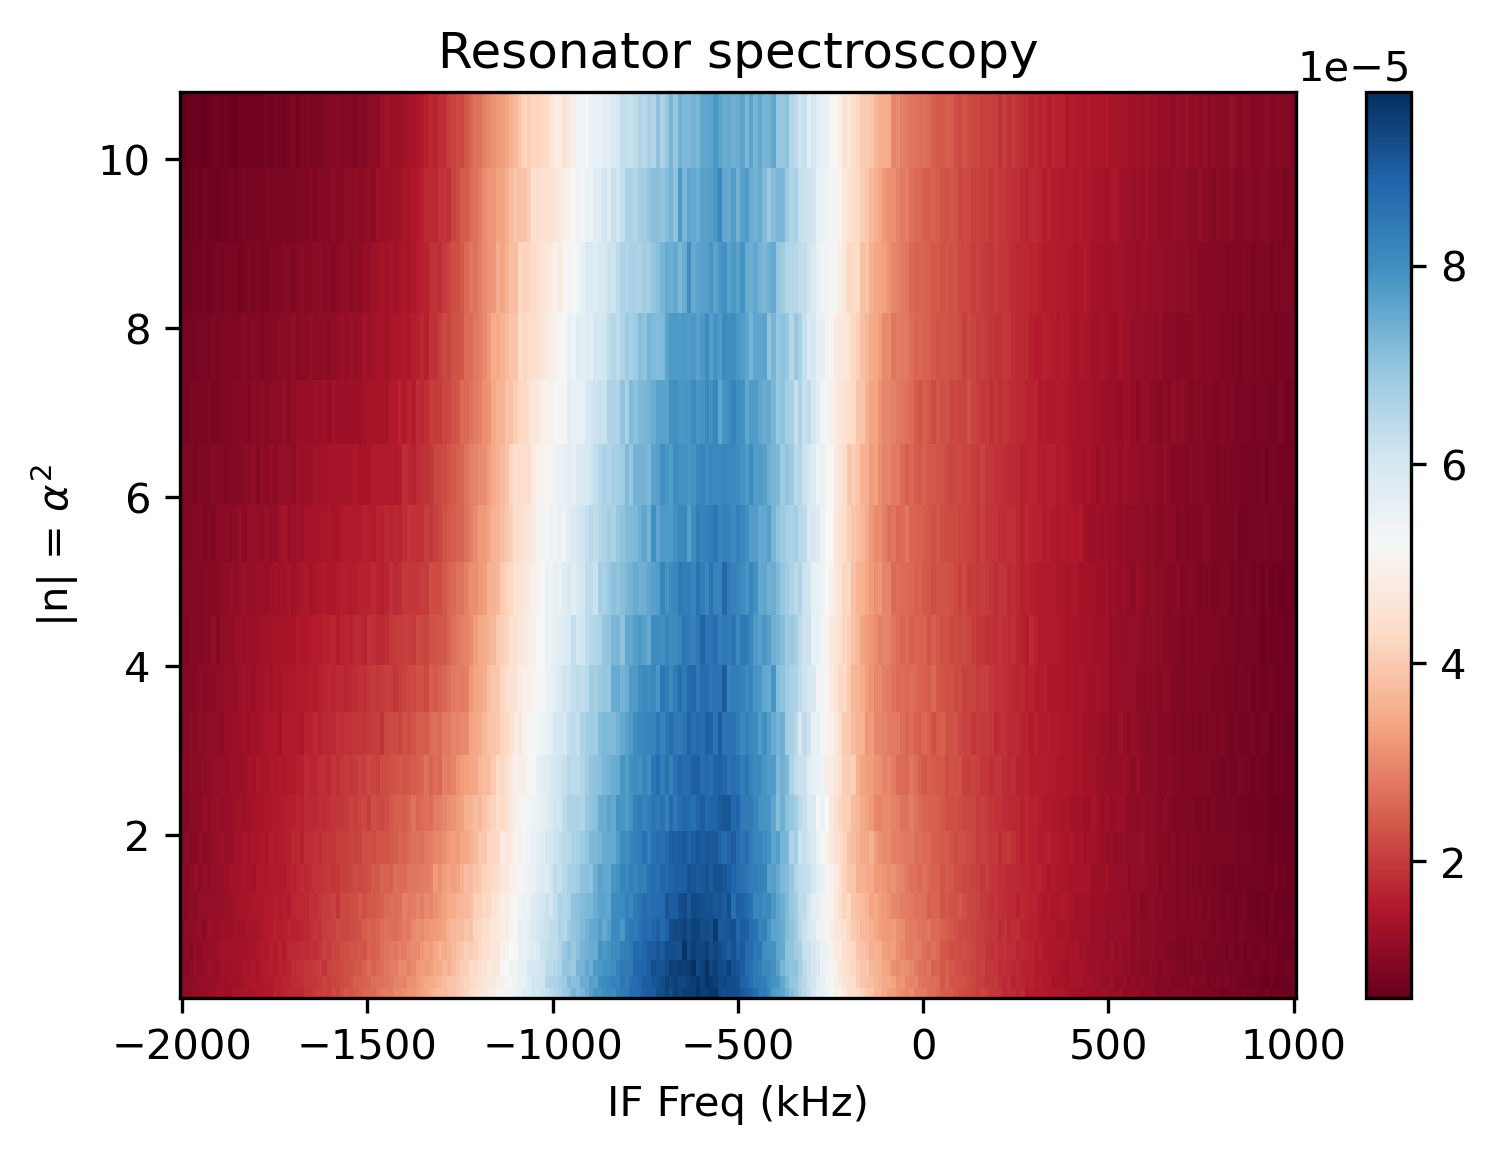

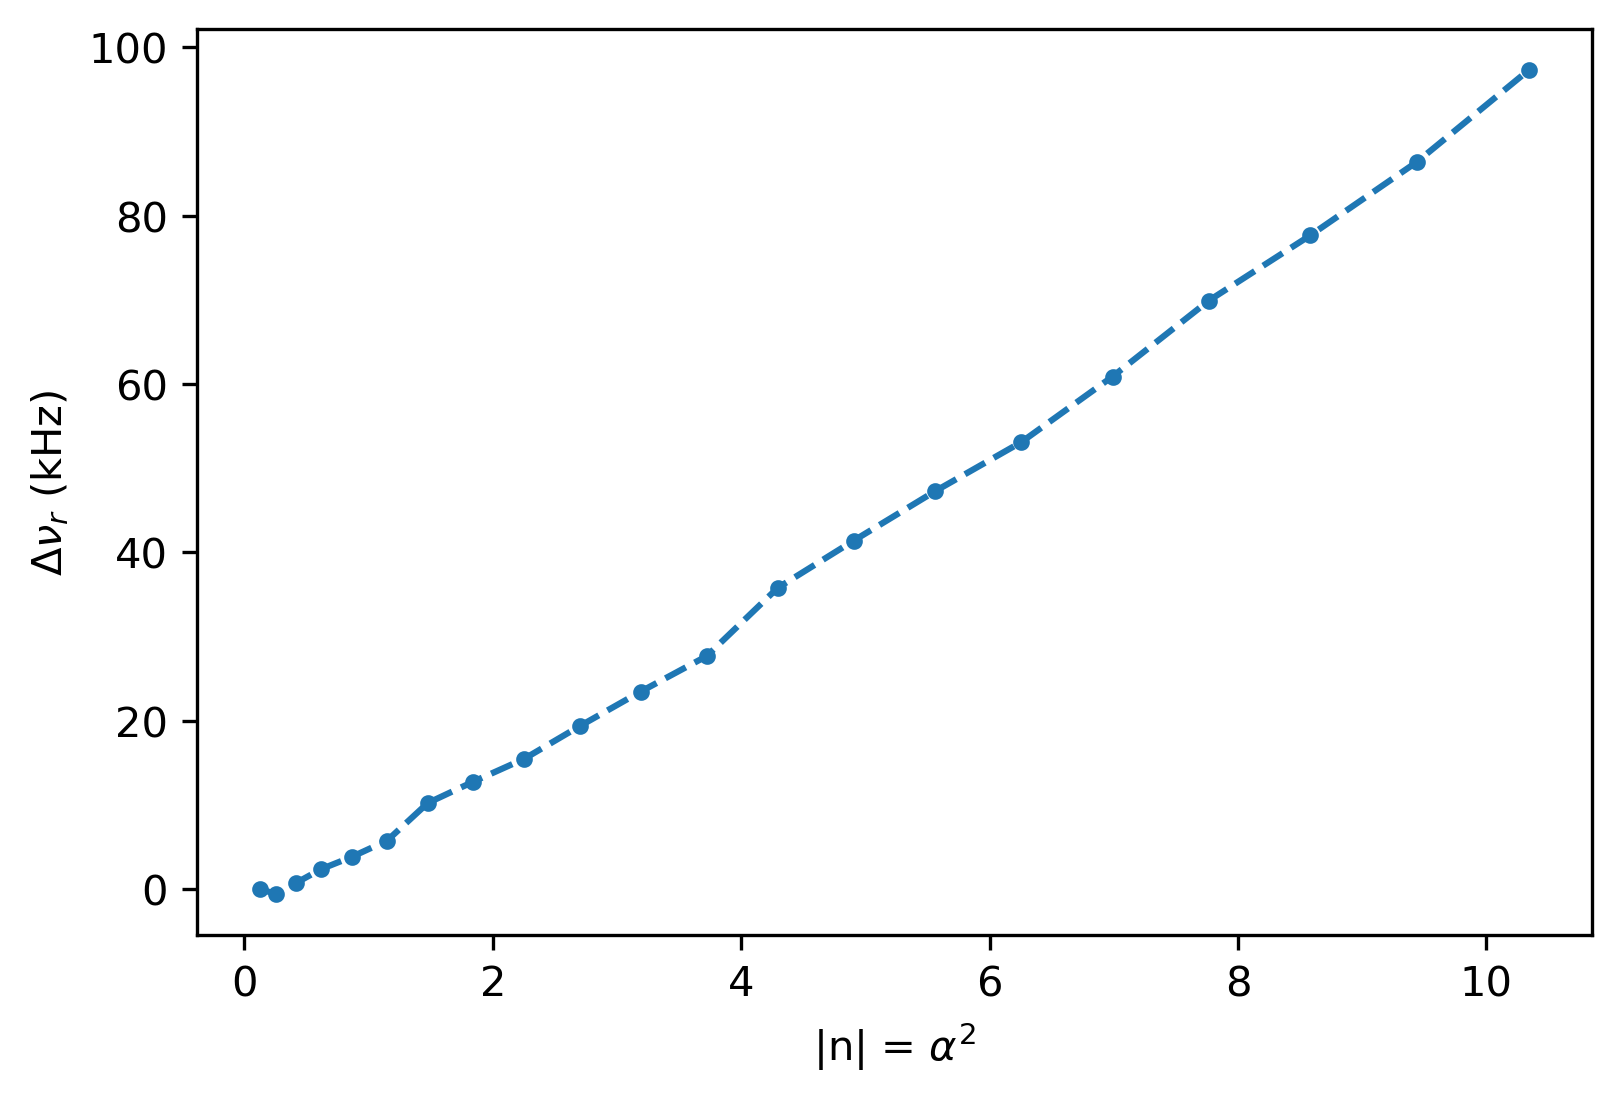

In [36]:
expt_name = 'resonator_spec_sq_alpha'
filelist = [1]
#3 - amp(0.5)
#4 - 8us long readout

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e3
        y = array(a['len'])
        a.close()

alpha = alpha_awg_cal(cav_amp=1.0, cav_len=y)

plt.figure(dpi=300)
plt.pcolormesh(x, alpha**2, I**2 + Q**2, shading='auto', cmap='RdBu')
plt.colorbar()
plt.title('Resonator spectroscopy')
plt.xlabel('IF Freq (kHz)')
plt.ylabel('|n| = $α^{2}$')
plt.show()

amps = I**2 + Q**2
f_res = []
for ii in range(len(I)):
    p = fitlor(x, amps[ii], showfit=False)
    f_res.append(p[2])
f_res = f_res - f_res[0]
plt.figure(dpi=300)
plt.plot(alpha**2, f_res, '.--')
plt.xlabel('|n| = $α^{2}$')
plt.ylabel(r'$\Delta \nu_{r}$ (kHz)')
plt.show()

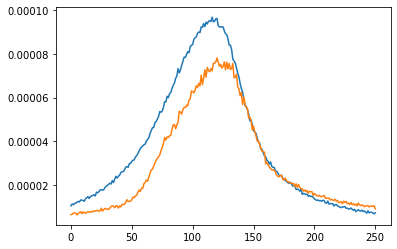

In [38]:
plt.plot(amps[0])
plt.plot(amps[-1])


In [114]:
def cross_kerr(K, omega_r, alpha, N):
    tot = abs(np.exp(-alpha**2)*(sum([alpha**(2*n)*np.exp(-1j*t*(K*n))/ \
                                   scipy.special.factorial(n) for n in arange(N)])))**2


## Optimal

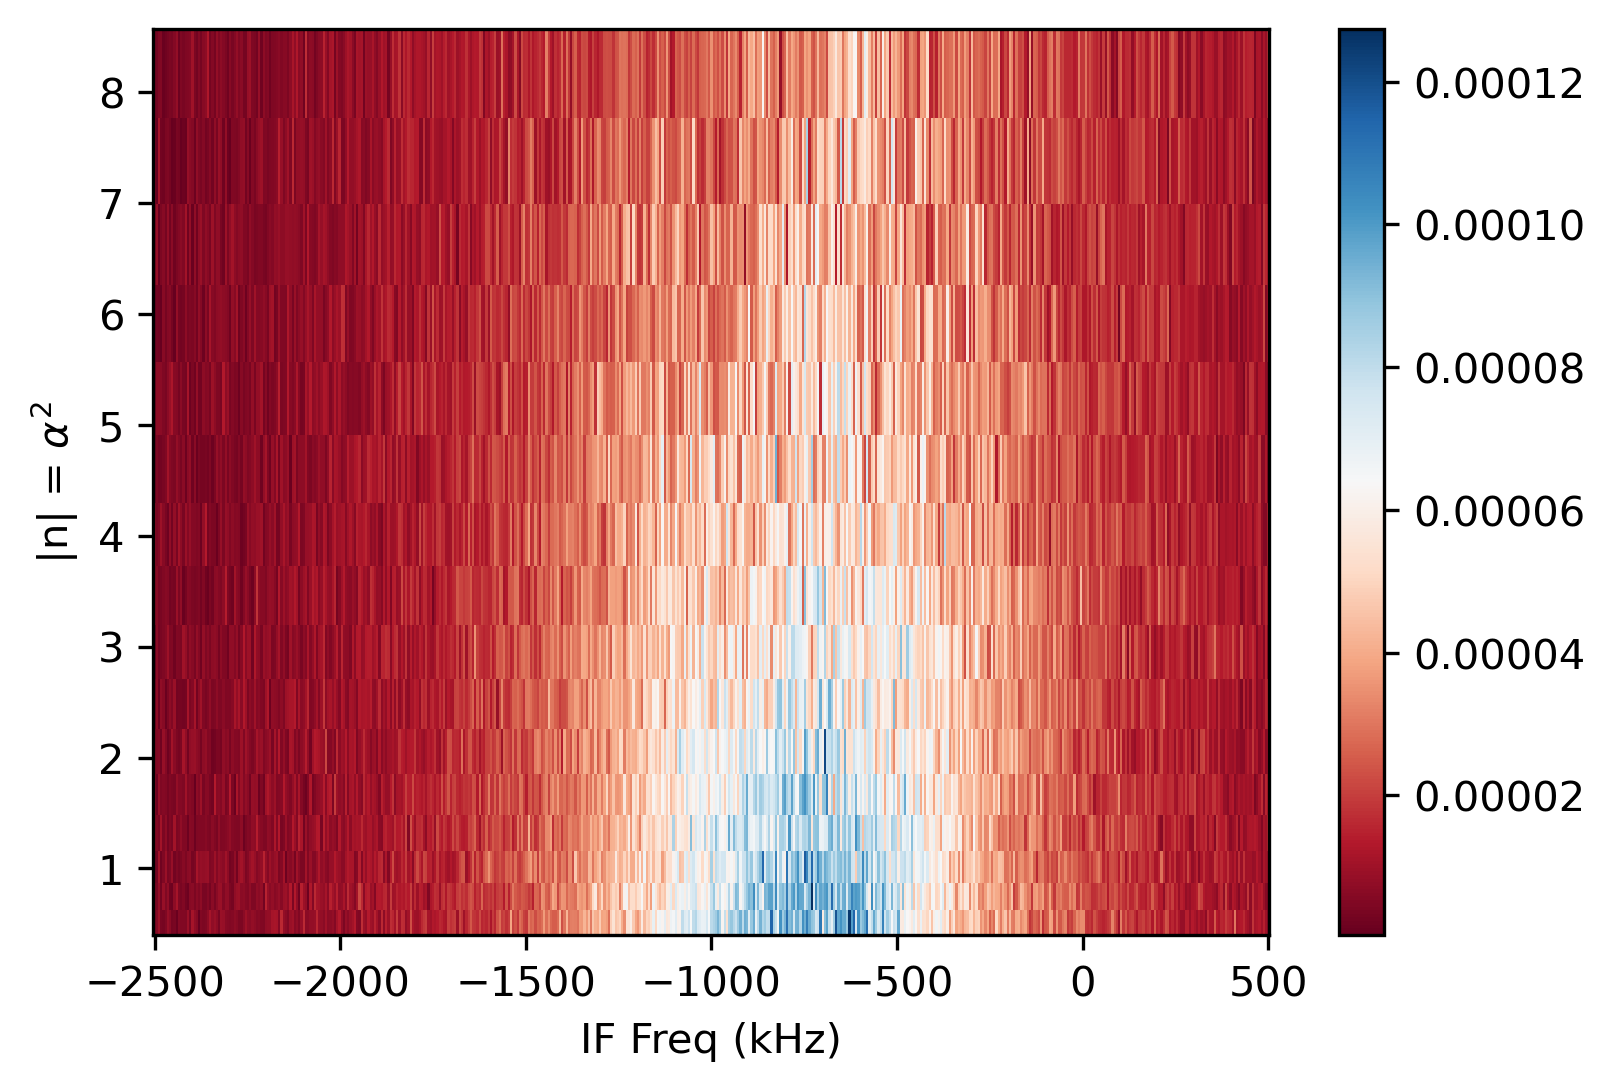

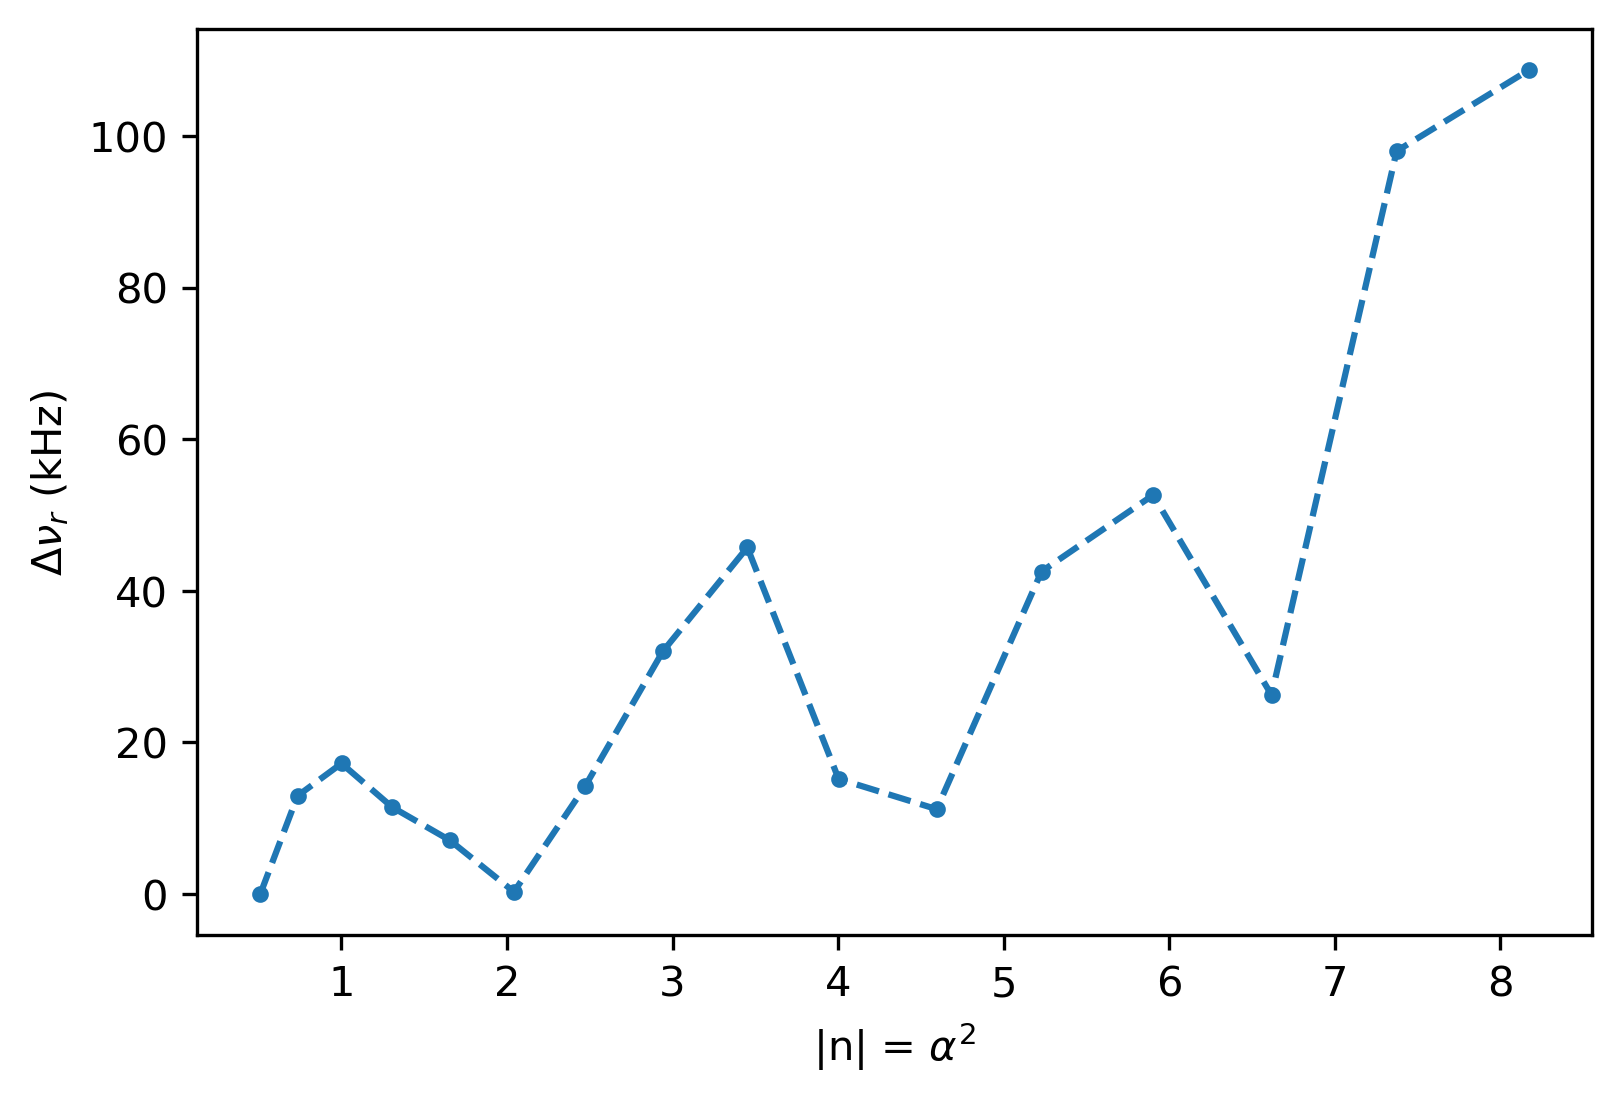

In [31]:
expt_name = 'resonator_spec_opt_alpha'
filelist = [3]
#3 - amp(0.5)
#4 - 8us long readout

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e3
        y = array(a['len'])
        a.close()

alpha = alpha_awg_cal(cav_amp=1.0, cav_len=y)

plt.figure(dpi=300)
plt.pcolormesh(x, alpha**2, I**2 + Q**2, shading='auto', cmap='RdBu')
plt.colorbar()
plt.xlabel('IF Freq (kHz)')
plt.ylabel('|n| = $α^{2}$')
plt.show()

amps = I**2 + Q**2
f_res = []
for ii in range(len(I)):
    p = fitlor(x, amps[ii], showfit=False)
    f_res.append(p[2])
f_res = f_res - f_res[0]
plt.figure(dpi=300)
plt.plot(alpha**2, f_res, '.--')
plt.xlabel('|n| = $α^{2}$')
plt.ylabel(r'$\Delta \nu_{r}$ (kHz)')
plt.show()

# Power Rabi 

## Fast

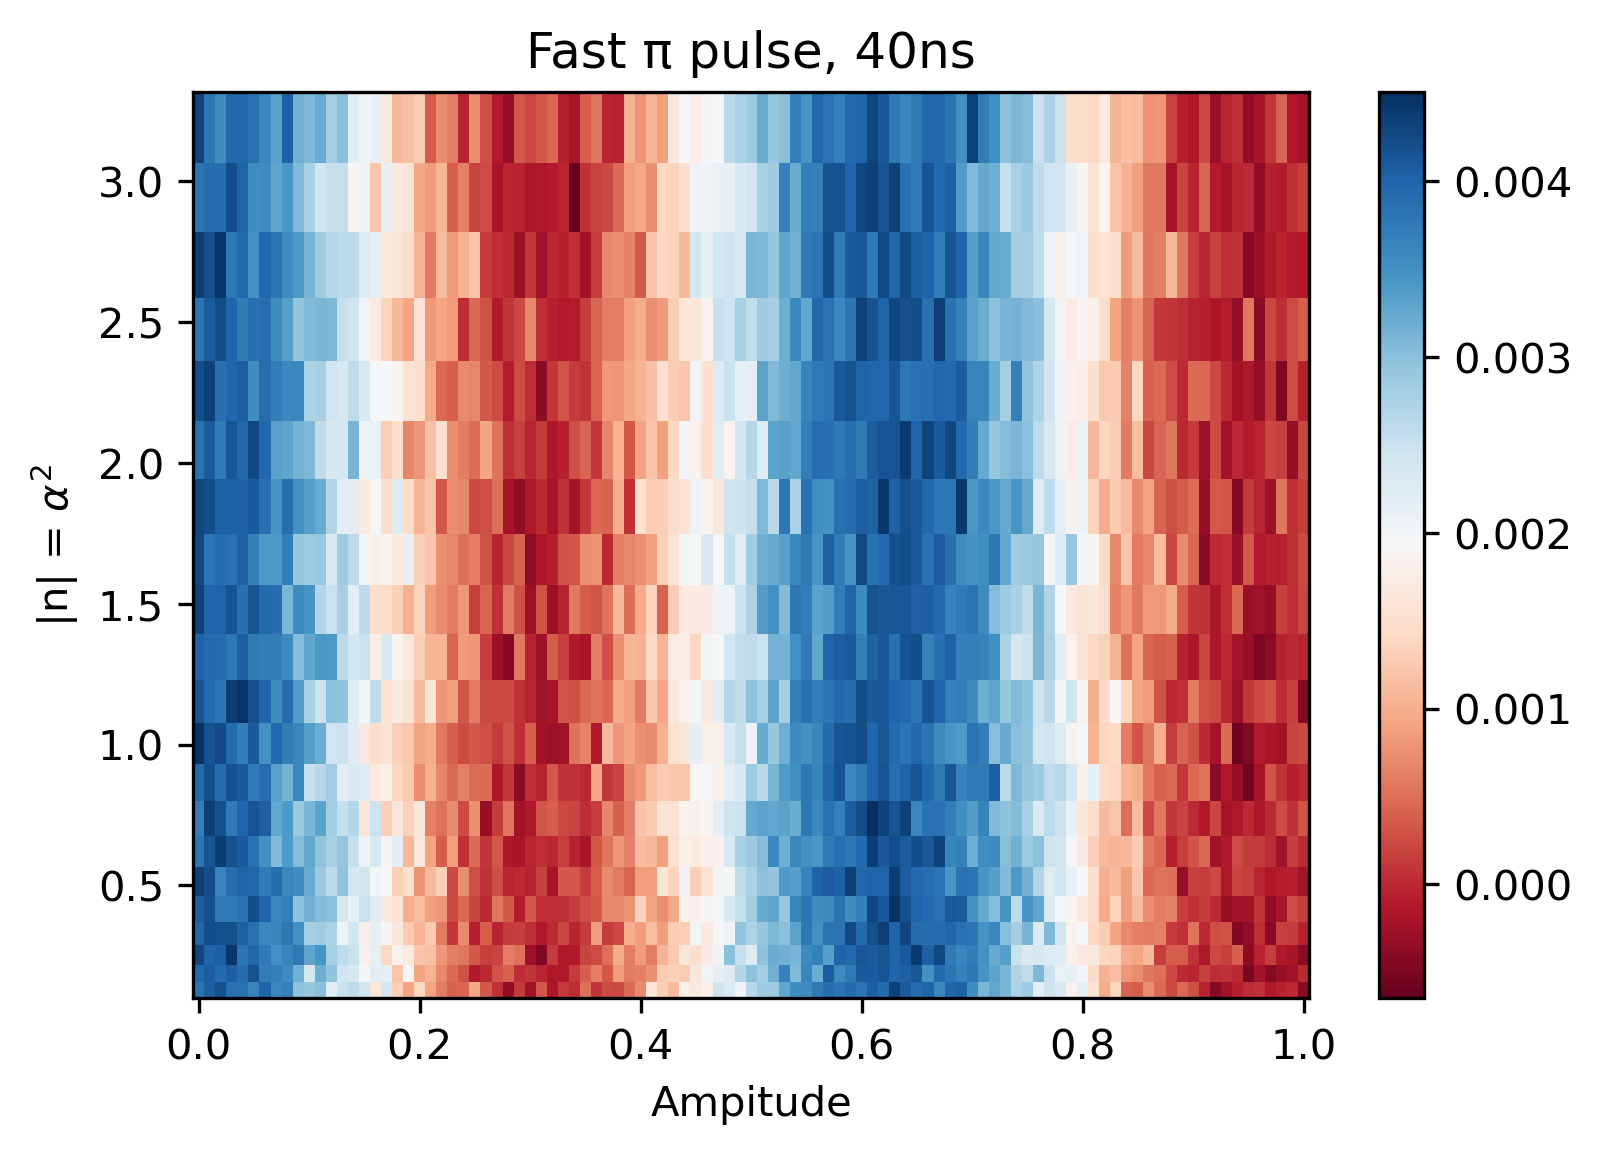

C:\_Lib\python\slab\dsfit.py:263: RuntimeWarning: overflow encountered in power
  decaysin3 = lambda p, x: p[0] * np.sin(2. * np.pi * p[1] * x + p[2] * np.pi / 180.) * np.e ** (


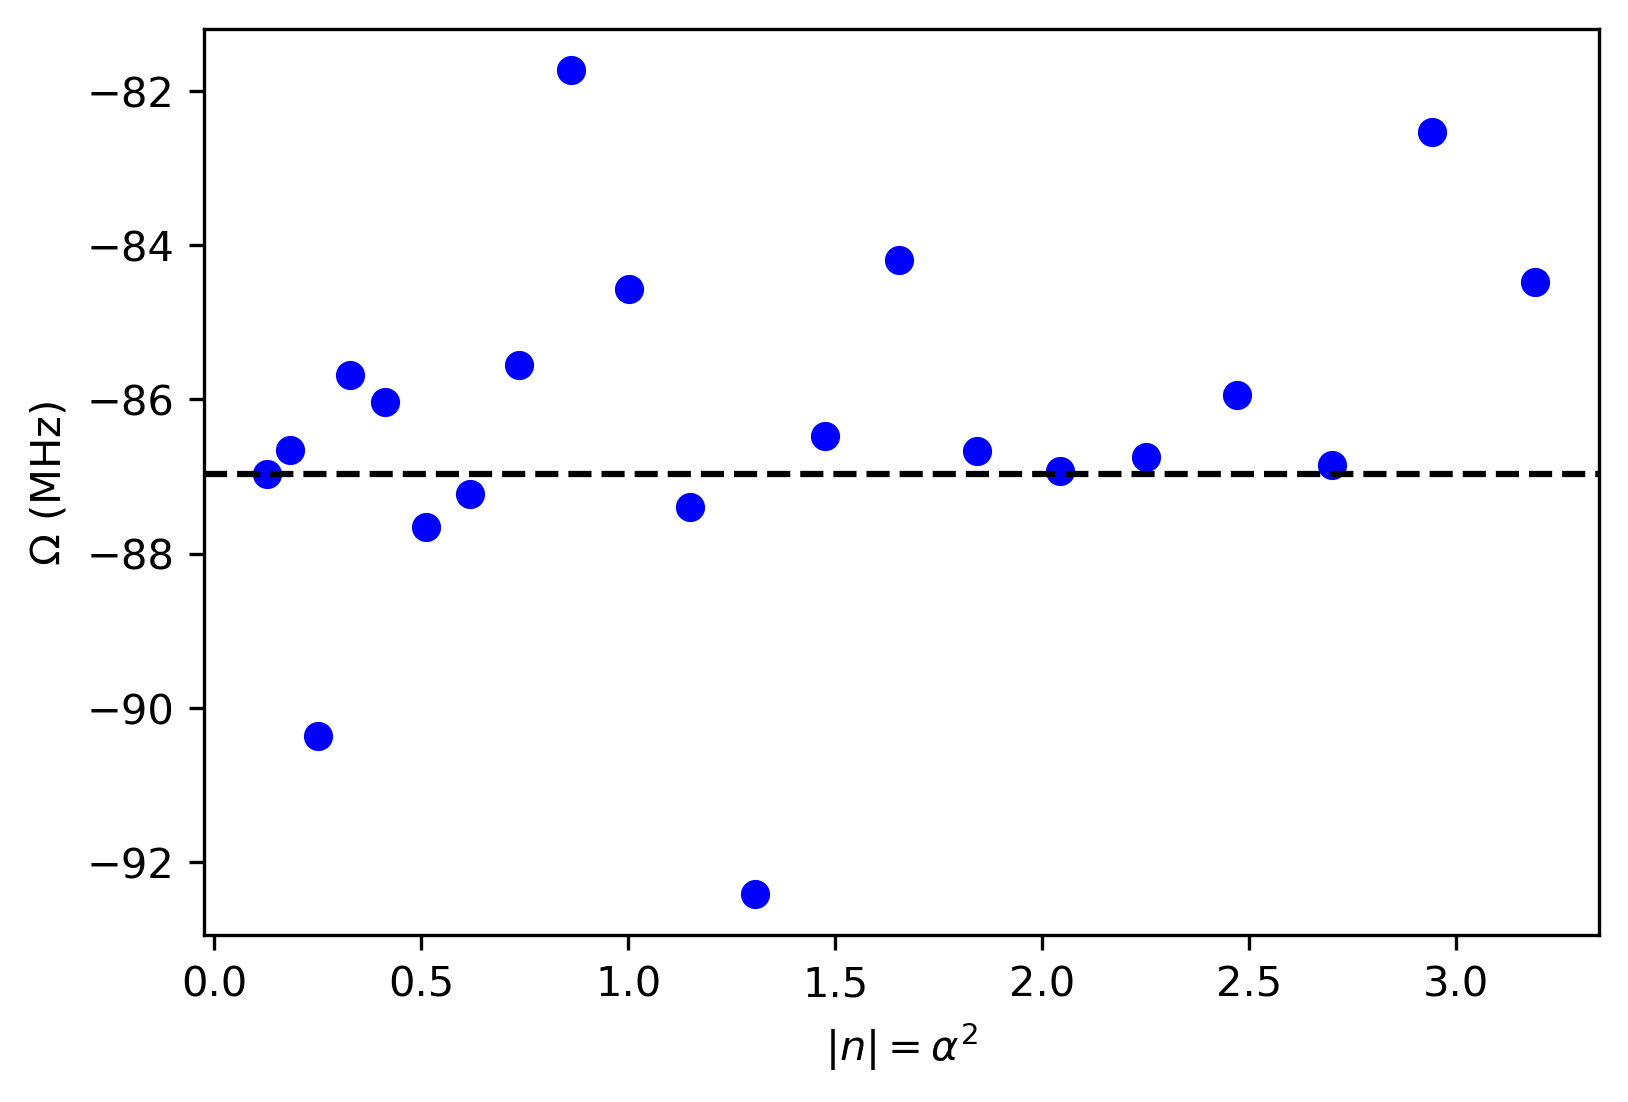

In [39]:
def rabi_freq(x, y):
    popt = fitdecaysin(x, y,fitparams = None, showfit=False)
    return popt[2]

expt_name = 'power_rabi_alpha'
filelist = [2]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['amps'])
        y = array(a['len'])

alphas = alpha_awg_cal(cav_amp=1.0, cav_len=y)
plt.figure(dpi=300)
plt.title('Fast π pulse, 40ns')

plt.pcolormesh(x, alphas**2, Q, shading='auto', cmap='RdBu')
plt.colorbar()
plt.xlabel('Ampitude')
plt.ylabel('|n| = $α^{2}$')
plt.show()

fig, ax = plt.subplots(1, 1, dpi=300)

df = pd.DataFrame(Q)
rabi = df.apply(lambda row: rabi_freq(x, row), axis=1)

ax.plot(alphas**2, rabi, 'bo')
ax.axhline(rabi[0], color='k', linestyle='--')
ax.set_ylabel(r'$\mathrm{\Omega}$ (MHz)')
ax.set_xlabel(r'$|n| = \alpha^{2}$')
plt.show()

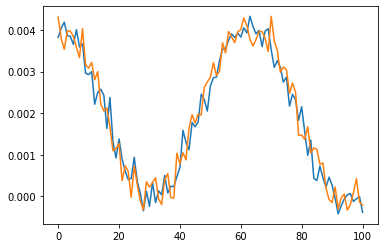

In [40]:
plt.plot(Q[0])
plt.plot(Q[-1])

## Resolved

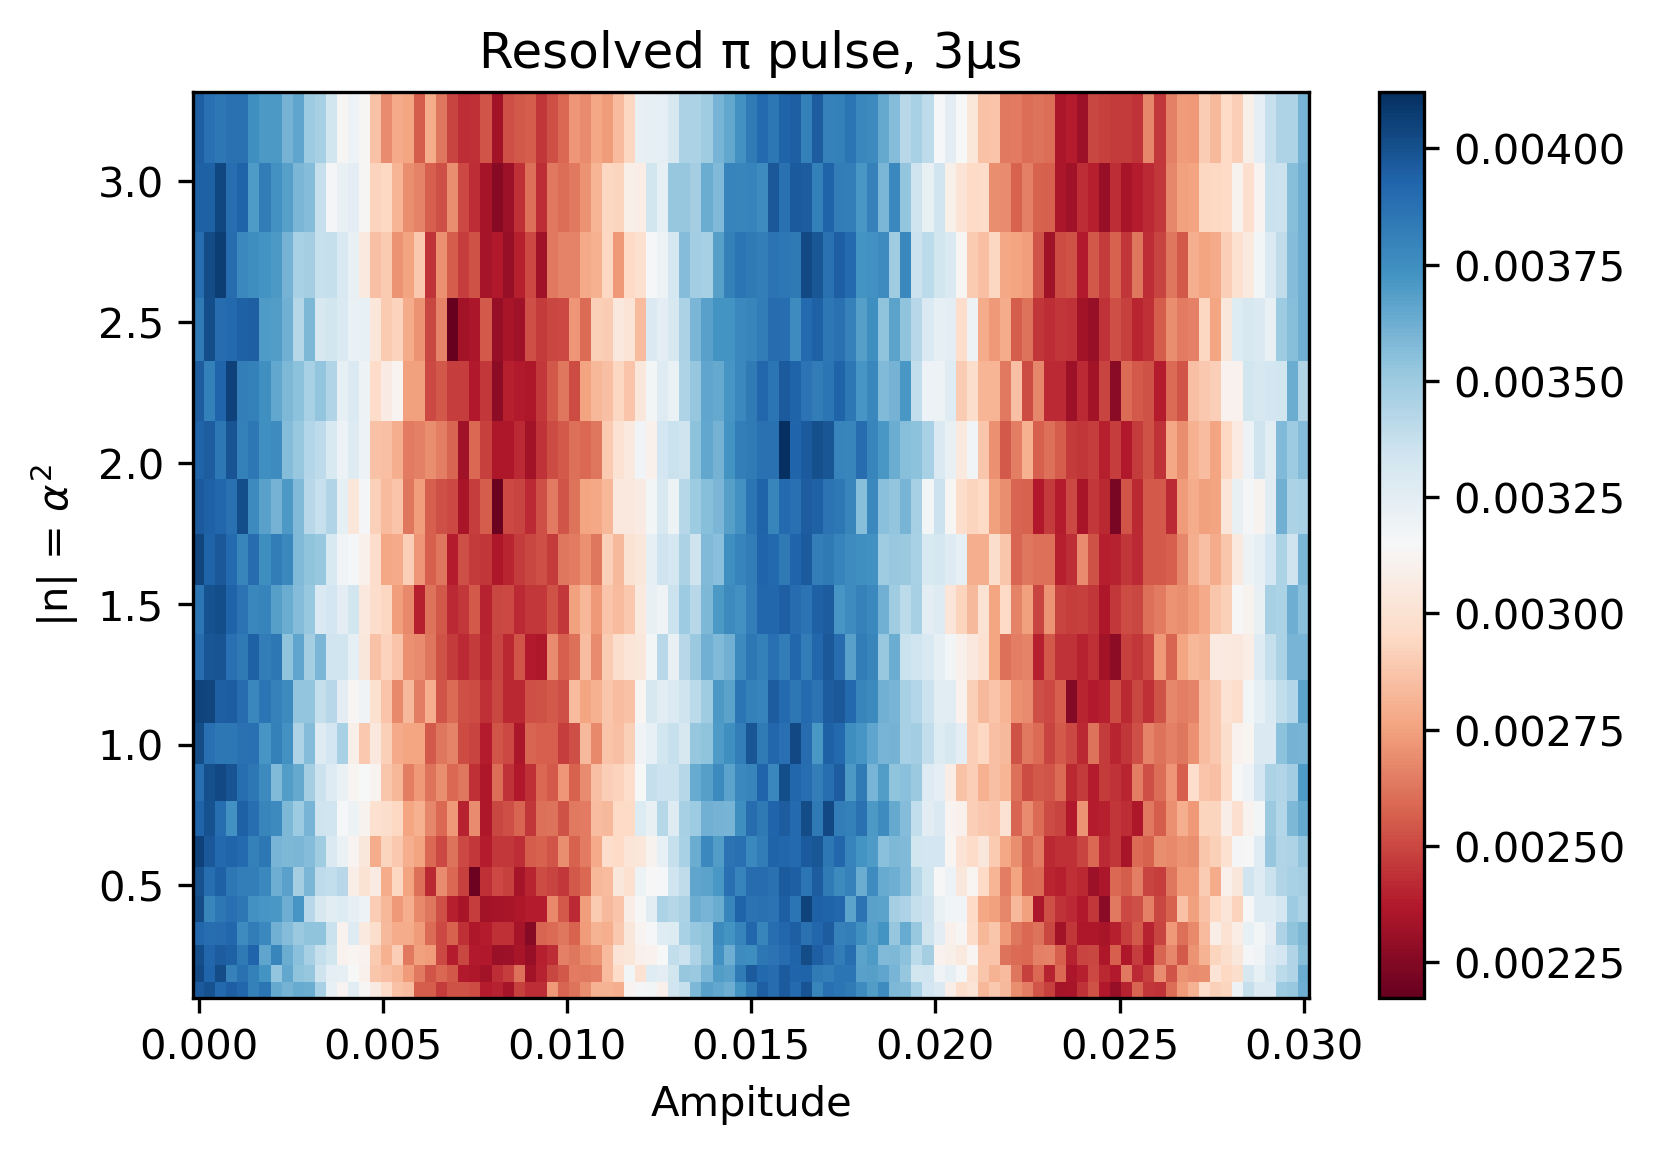

C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


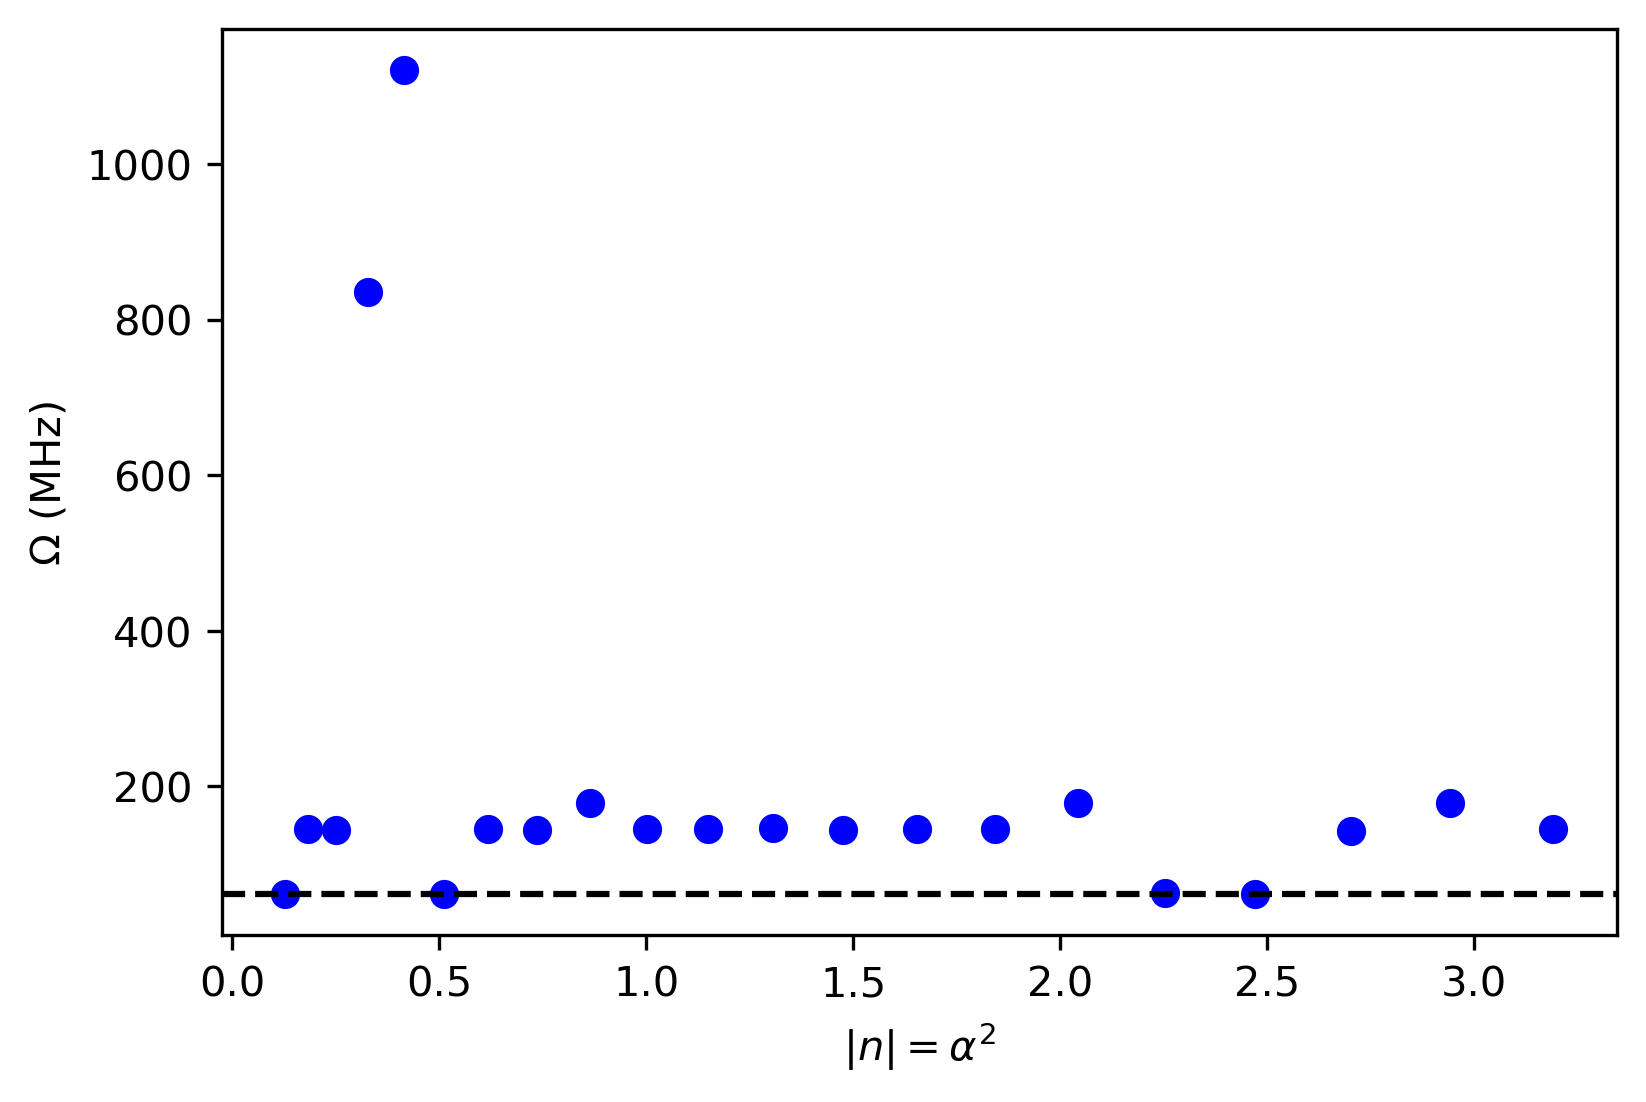

In [18]:
def rabi_freq(x, y):
    popt = fitdecaysin(x, y,fitparams = None, showfit=False)
    return popt[1]

expt_name = 'power_rabi_res_alpha'
filelist = [1]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['amps'])
        y = array(a['len'])

alphas = alpha_awg_cal(cav_amp=1.0, cav_len=y)
plt.figure(dpi=300)
plt.title('Resolved π pulse, 3μs')

plt.pcolormesh(x, alphas**2, Q, shading='auto', cmap='RdBu')
plt.colorbar()
plt.xlabel('Ampitude')
plt.ylabel('|n| = $α^{2}$')
plt.show()

fig, ax = plt.subplots(1, 1, dpi=300)

df = pd.DataFrame(Q)
rabi = df.apply(lambda row: rabi_freq(x, row), axis=1)

ax.plot(alphas**2, rabi, 'bo')
ax.axhline(rabi[0], color='k', linestyle='--')
ax.set_ylabel(r'$\mathrm{\Omega}$ (MHz)')
ax.set_xlabel(r'$|n| = \alpha^{2}$')
plt.show()

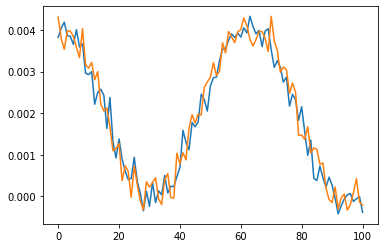

In [42]:
plt.plot(Q[0])
plt.plot(Q[-1])

# ge T1

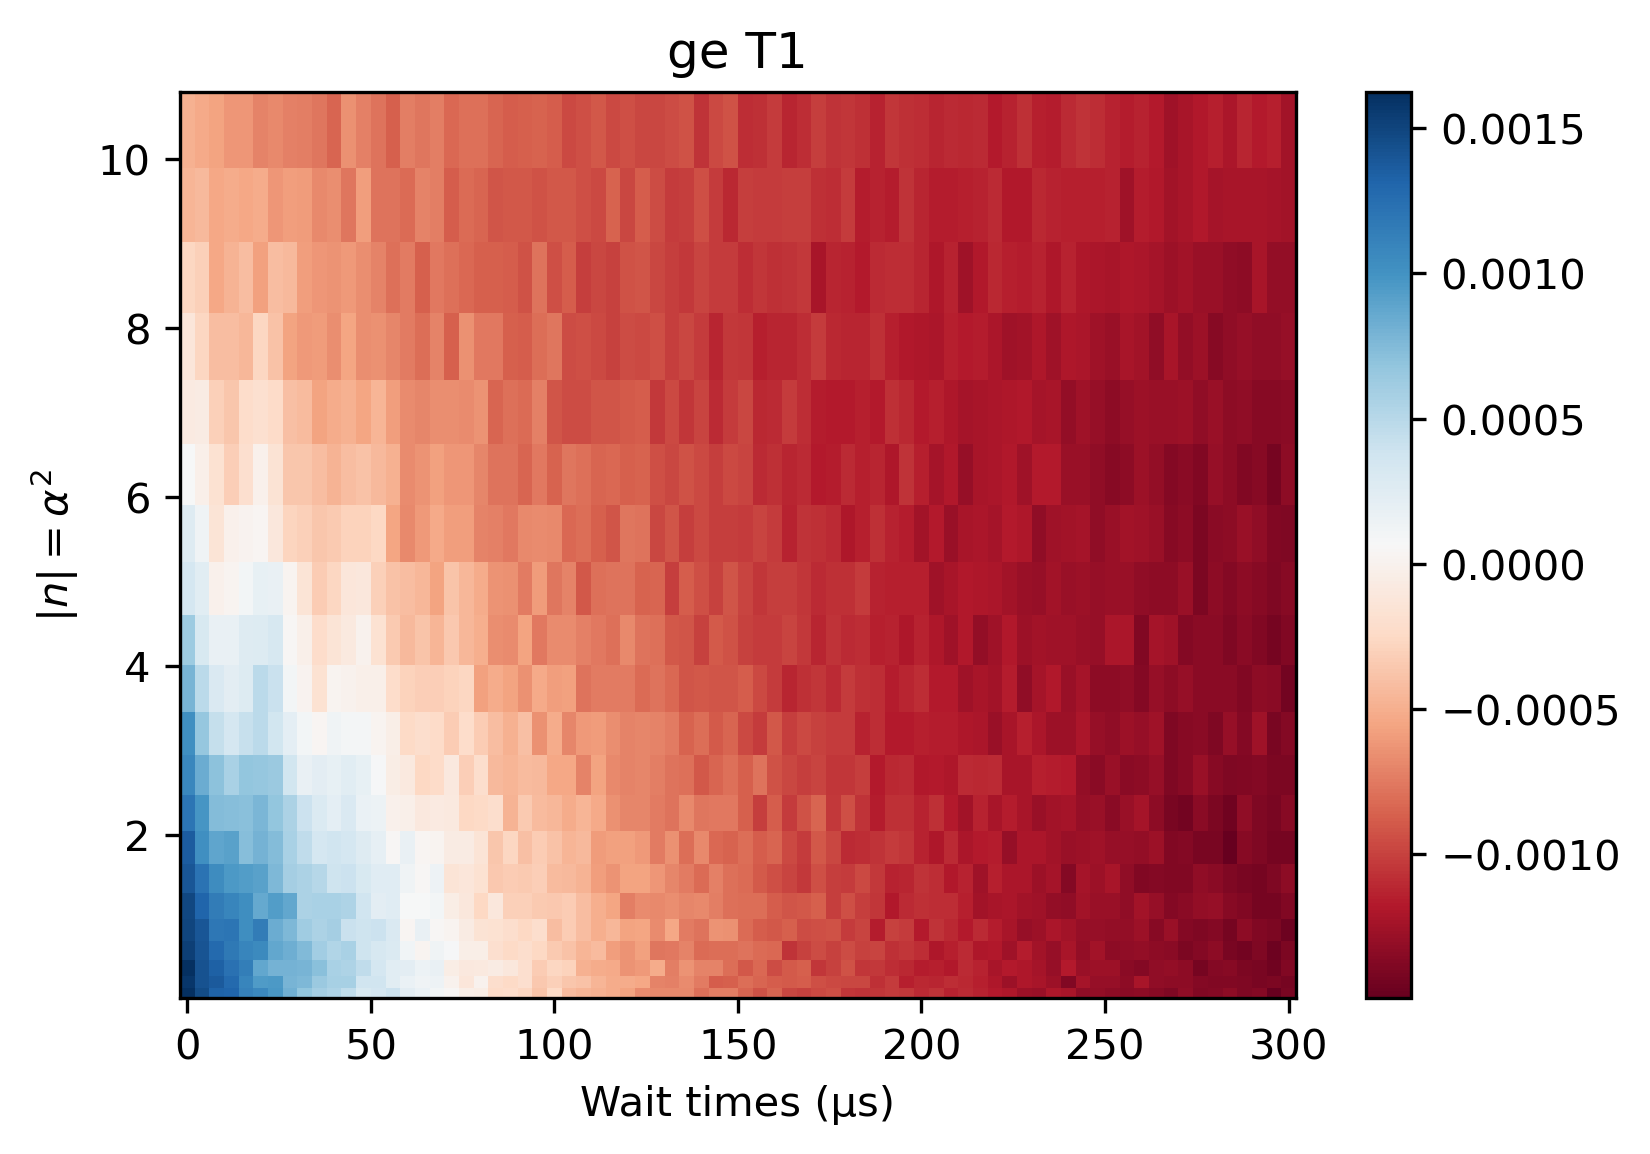

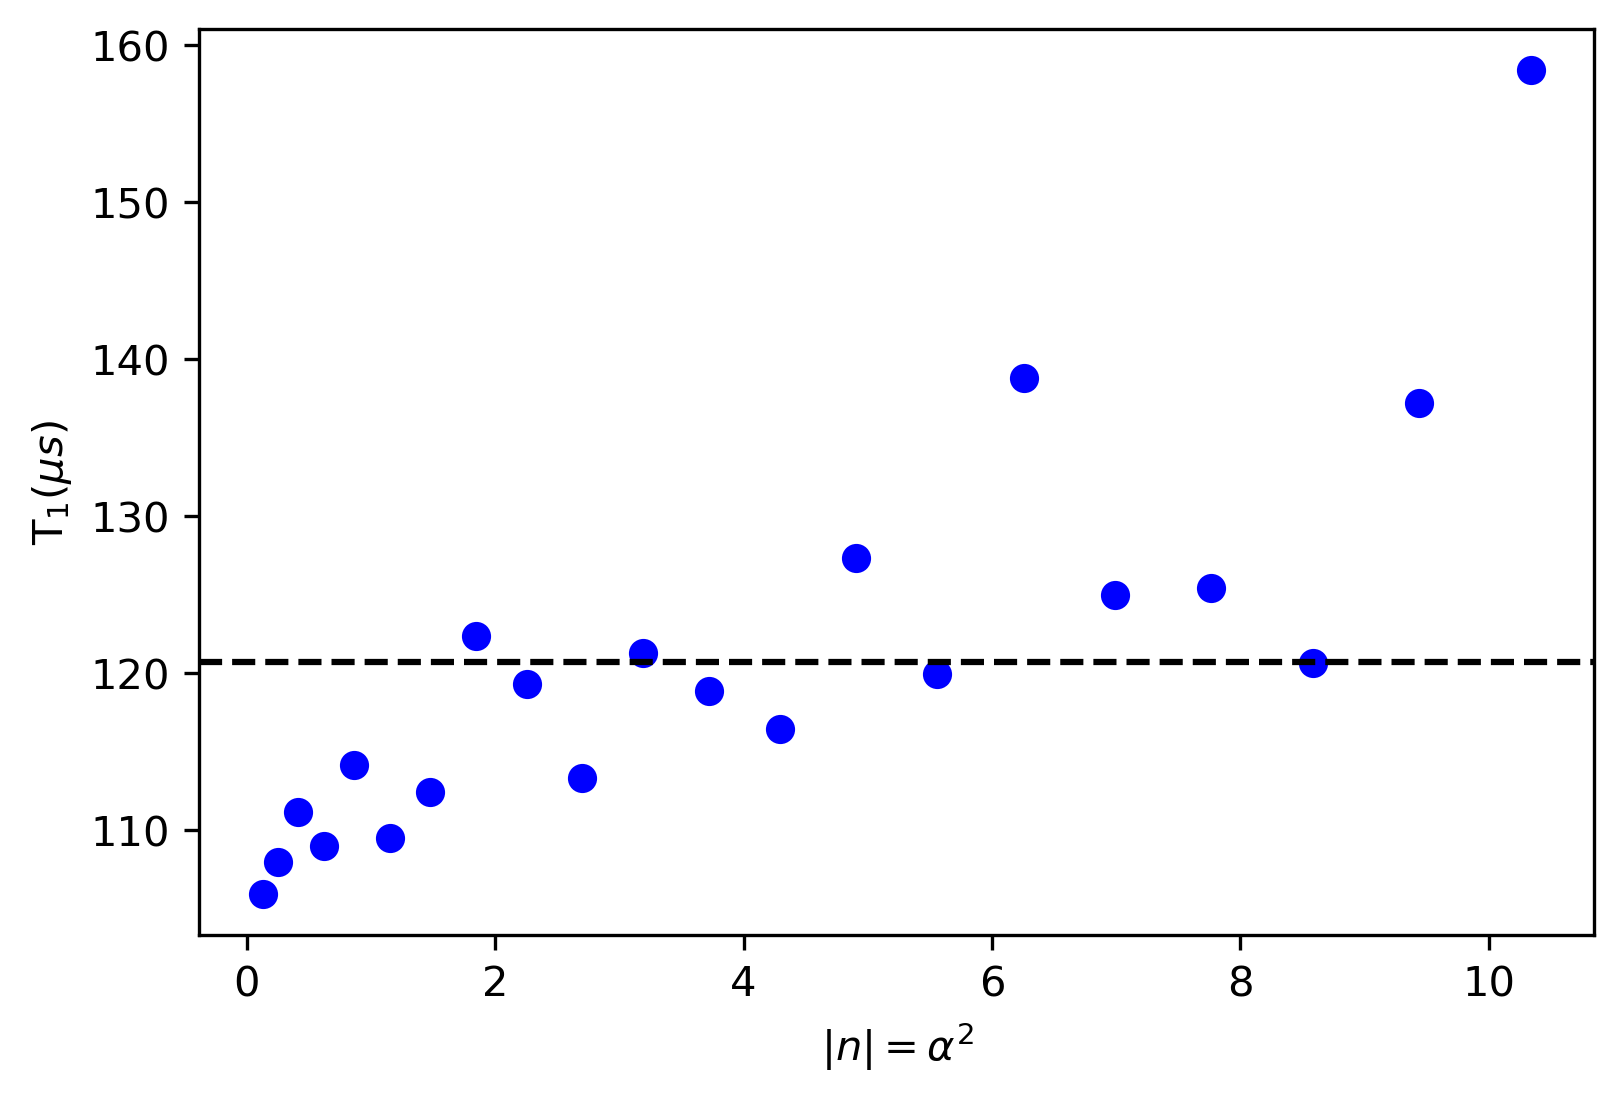

In [126]:
def t1(x, y):
    popt, pcov = curve_fit(expfunc_baseline, x, y)
    return popt[1]

expt_name = 't1_alpha'
filelist = [3]
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        wait_times = array(a['time'])
        cav_len = array(a['len'])

alphas = alpha_awg_cal(cav_amp=1.0, cav_len=cav_len)

fig, ax = plt.subplots(1, 1, dpi=300)

d = plt.pcolormesh(wait_times, alphas**2, I, cmap='RdBu', shading='auto')
plt.colorbar()
plt.title('ge T1')
plt.xlabel('Wait times (μs)')
plt.ylabel(r'$|n| = \alpha^{2}$')
plt.show()

fig, ax = plt.subplots(1, 1, dpi=300)

df = pd.DataFrame(I)
t1_alpha = df.apply(lambda row: t1(wait_times, row), axis=1)

ax.plot(alphas**2, t1_alpha, 'bo')
ax.axhline(np.mean(t1_alpha), color='k', linestyle='--')
ax.set_ylabel(r'$\mathrm{T_{1}} (μs)$')
ax.set_xlabel(r'$|n| = \alpha^{2}$')
plt.show()

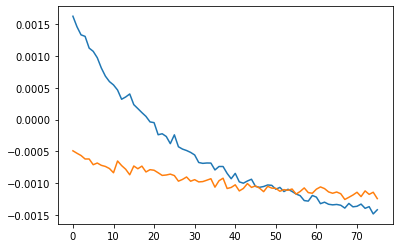

In [125]:
plt.plot(I[0])
plt.plot(I[-1])

# IQ Blobs

In [117]:
expt_name = 'histogram_sq_alpha'
filelist = [3]
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        avgs = array(a['avgs'])
        cav_len = array(a['len'])
alphas = alpha_awg_cal(cav_amp=1.0, cav_len=cav_len)

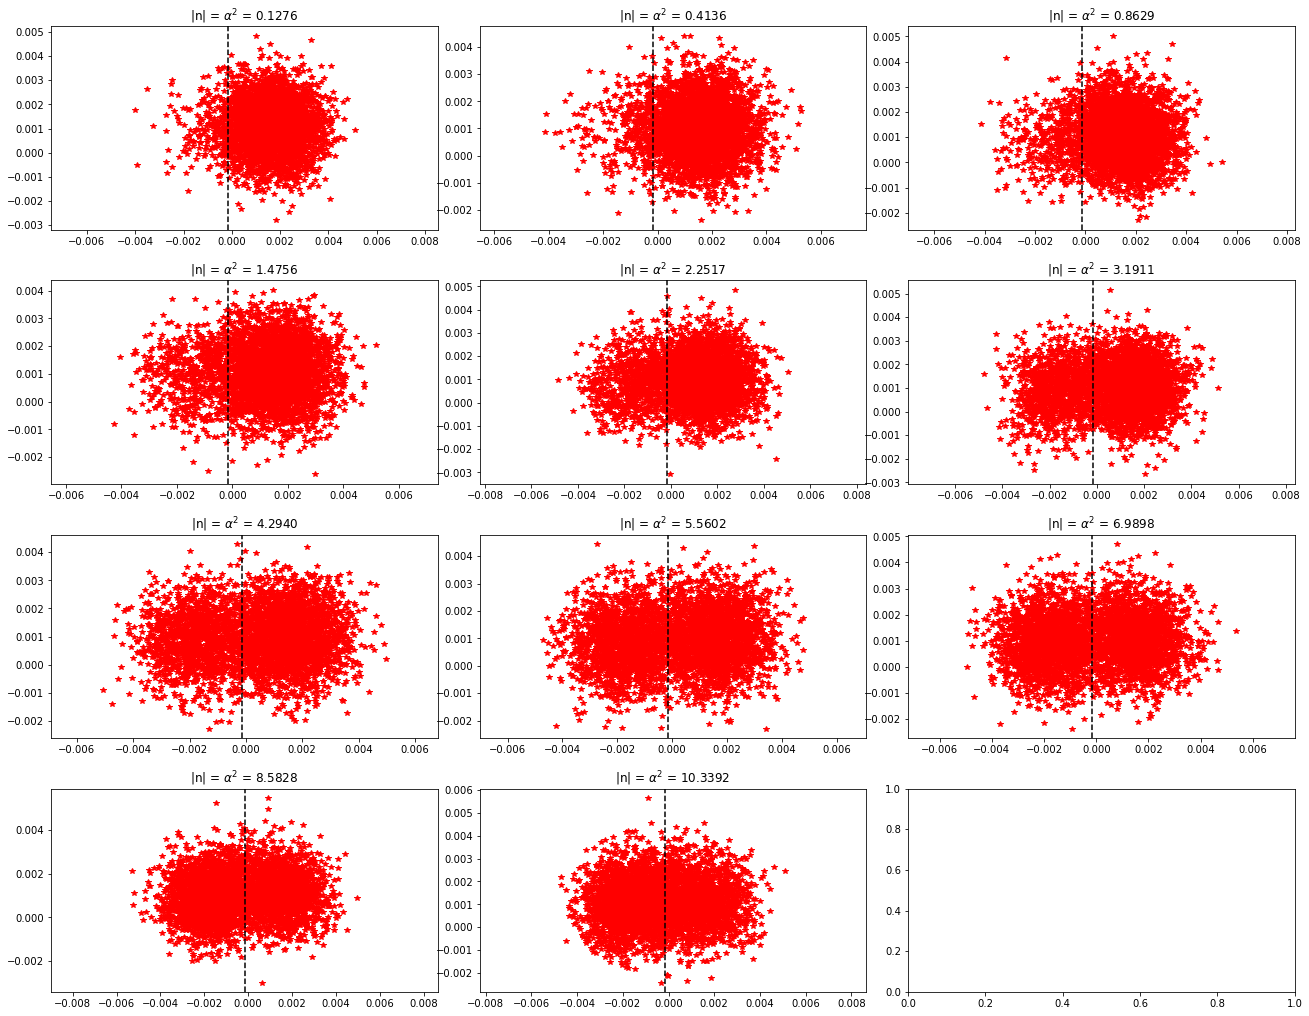

In [122]:
fig, axs = plt.subplots(nrows=len(cav_len)//3+len(cav_len)%3-1, ncols=3, figsize=(18, 4*len(cav_len)//3))
fig.tight_layout()
plt.subplots_adjust(hspace=0.25)
# left  = 0.125  # the left side of the subplots of the figure
# right = 0.9    # the right side of the subplots of the figure
# bottom = 0.1   # the bottom of the subplots of the figure
# top = 0.9      # the top of the subplots of the figure
# wspace = 0.2   # the amount of width reserved for blank space between subplots
# hspace = 0.2 
avgs = 4000
for jj in range(len(cav_len)):
    ax = axs[jj//3, jj%3]
    ax.set_title('|n| = $α^{2}$ = %.4f'%alphas[jj]**2)
#     ax.plot(Ig[jj*avgs:(jj+1)*avgs], Qg[jj*avgs:(jj+1)*avgs], 'b*')
    ax.plot(Ie[jj*avgs:(jj+1)*avgs], Qe[jj*avgs:(jj+1)*avgs], 'r*')
    ax.axvline(x=-0.00015, linestyle='--', color='k')
    ax.axis('equal')
plt.show()

## SNAP

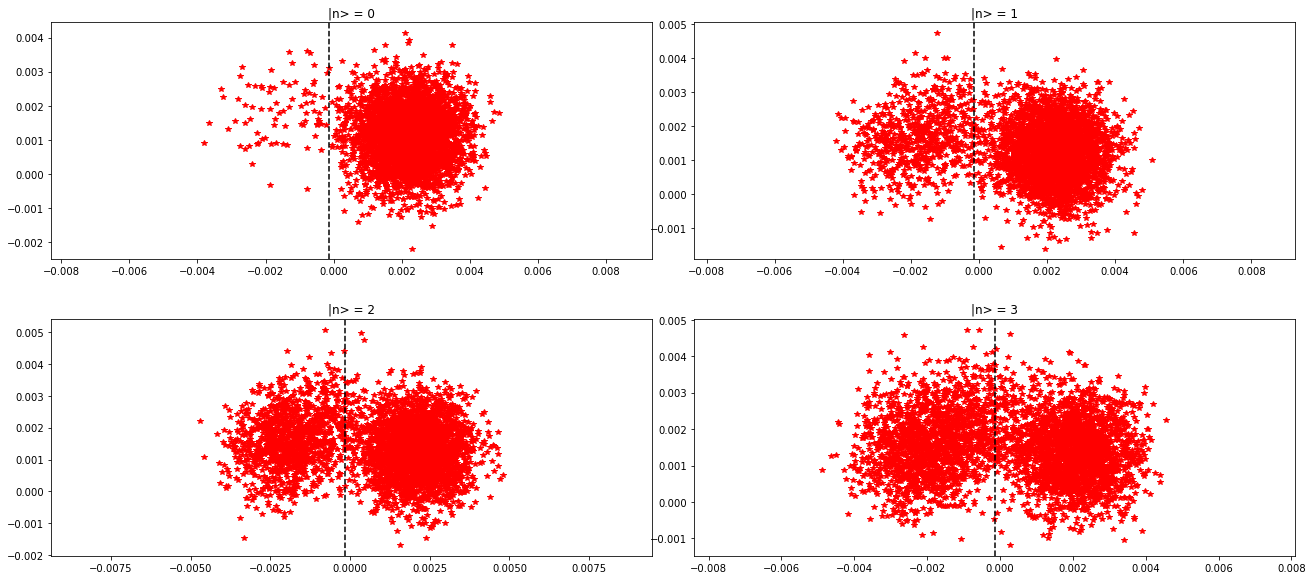

In [112]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 4*(4)//2))
fig.tight_layout()
plt.subplots_adjust(hspace=0.25)

expt_name = 'histogram_sq_fock'
filelist = [0, 1, 2, 3]
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        fock = array(a['fock'])
        
    ax = axs[i//2, i%2]
    ax.set_title('|n> = %.f'%fock)
#     ax.plot(Ig, Qg, 'b*')
    ax.plot(Ie, Qe, 'r*')
    ax.axvline(x=-0.00015, linestyle='--', color='k')
    ax.axis('equal')
plt.show()

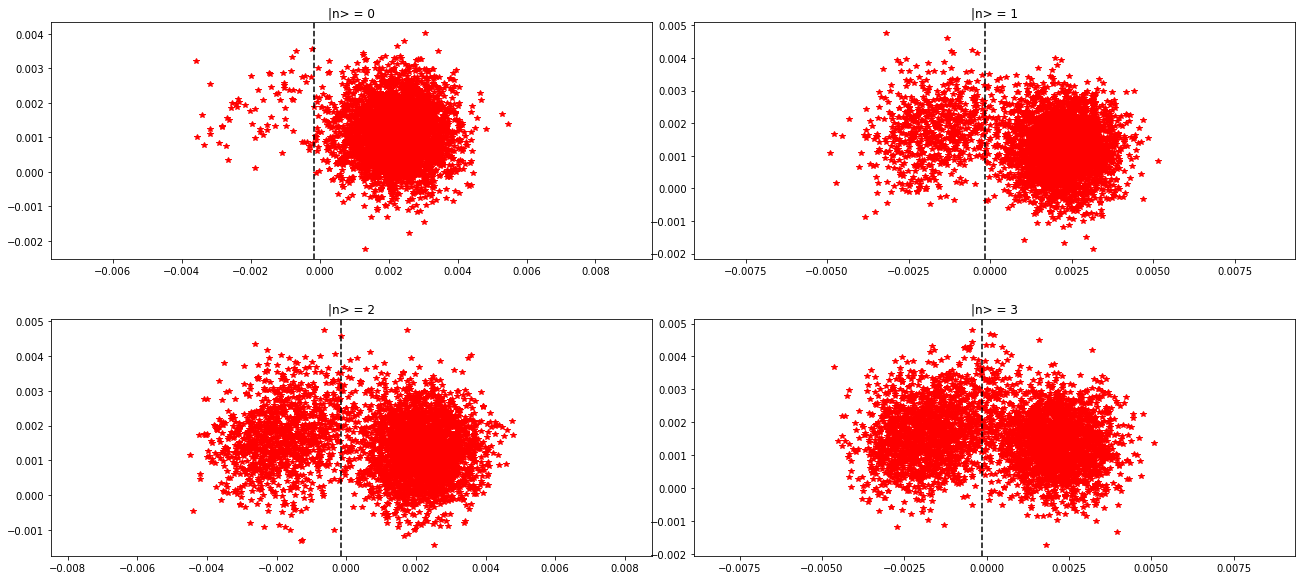

In [113]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 4*(4)//2))
fig.tight_layout()
plt.subplots_adjust(hspace=0.25)

expt_name = 'histogram_sq_fock'
filelist = [0, 1, 2, 3]
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i+4).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        fock = array(a['fock'])
        
    ax = axs[i//2, i%2]
    ax.set_title('|n> = %.f'%fock)
#     ax.plot(Ig, Qg, 'b*')
    ax.plot(Ie, Qe, 'r*')
    ax.axvline(x=-0.00015, linestyle='--', color='k')
    ax.axis('equal')
plt.show()

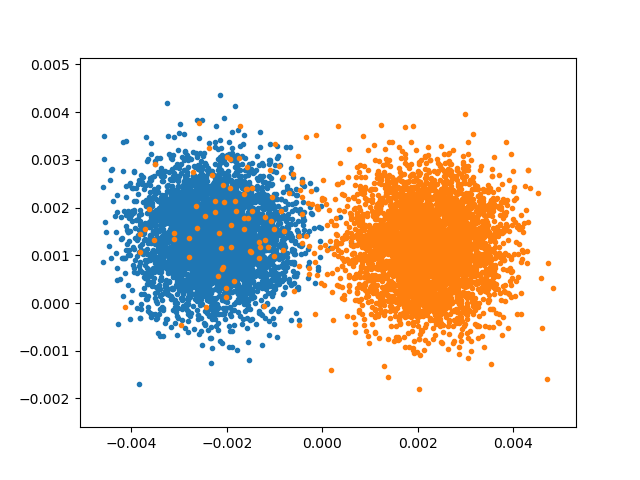

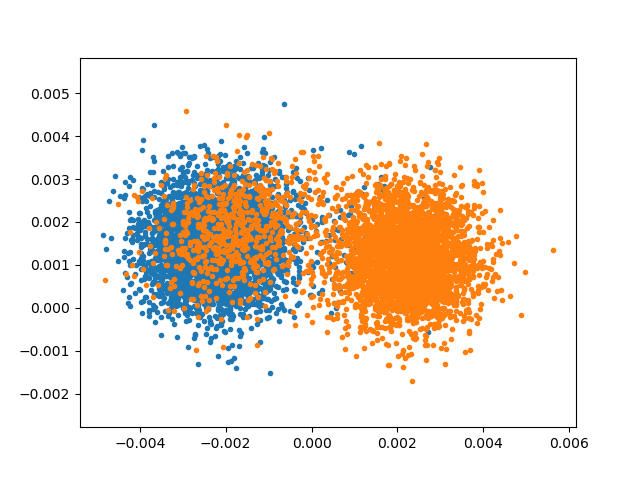

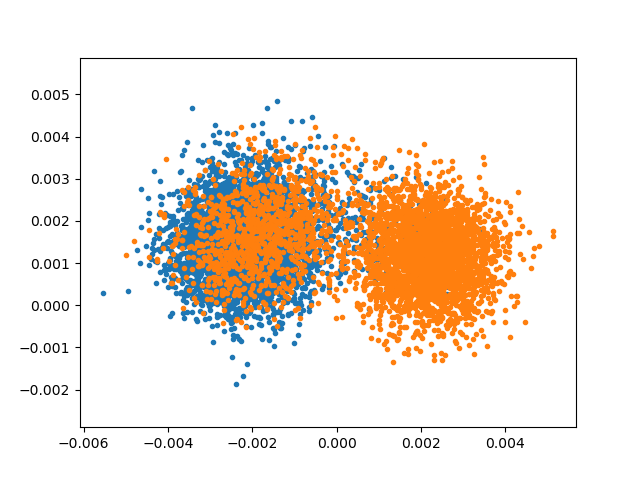

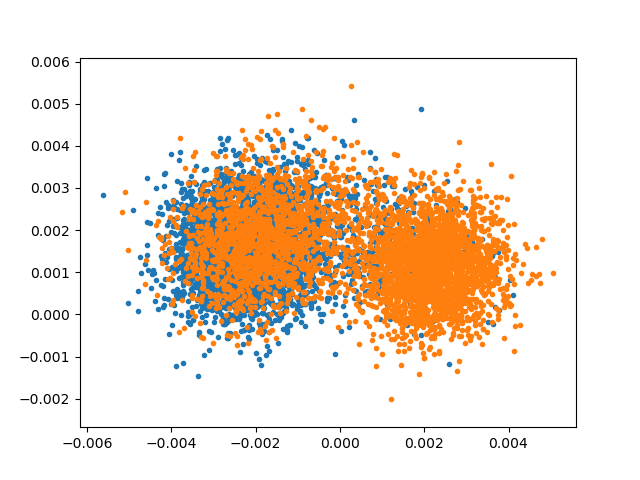

In [66]:
from IPython.display import Image, display
display(Image(filename='../figures/2021-12-27-histogram-fock0.png', embed=True))
display(Image(filename='../figures/2021-12-27-histogram-fock1.png', embed=True))
display(Image(filename='../figures/2021-12-27-histogram-fock2.png', embed=True))
display(Image(filename='../figures/2021-12-27-histogram-fock3.png', embed=True))

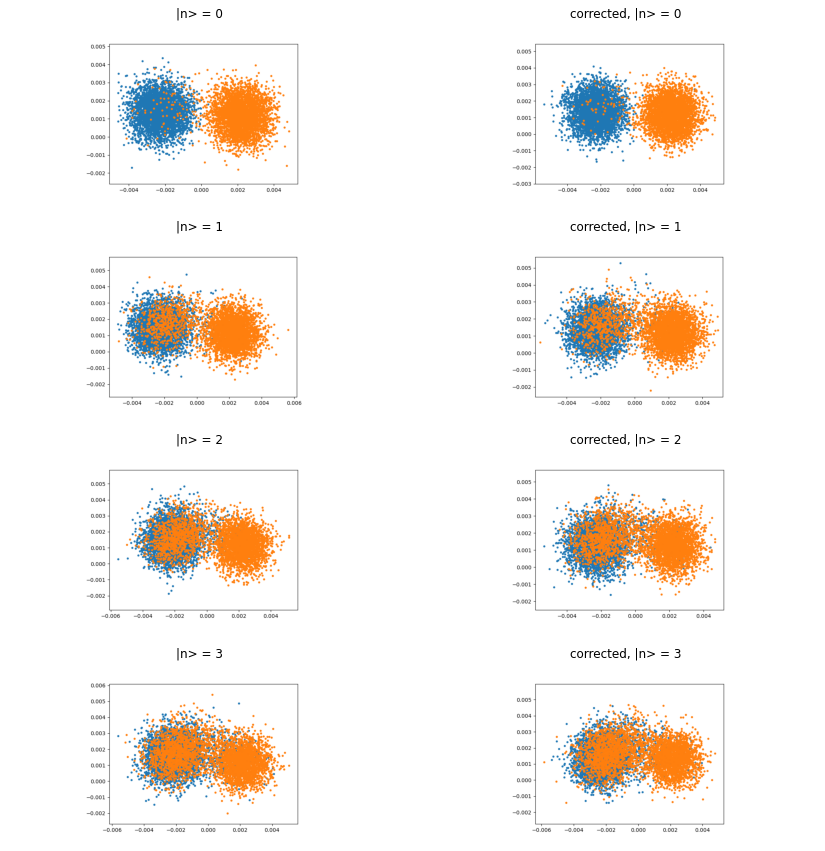

In [95]:
import matplotlib.image as mpimg

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
fig.tight_layout()
for ii in range(4):
    ax = axs[ii%4, 0]
    ax.set_title('|n> = %.f'%ii)
    img = mpimg.imread('../figures/2021-12-27-histogram-fock'+str(ii)+'.png')
    ax.imshow(img)
    ax.axis('equal')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.axis('off')
    
    ax = axs[ii%4, 1]
    ax.set_title('corrected, |n> = %.f'%ii)
    img = mpimg.imread('../figures/2021-12-27-histogram-fock'+str(ii)+'-corr.png')

    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.imshow(img)
    ax.axis('equal')
    ax.axis('off')

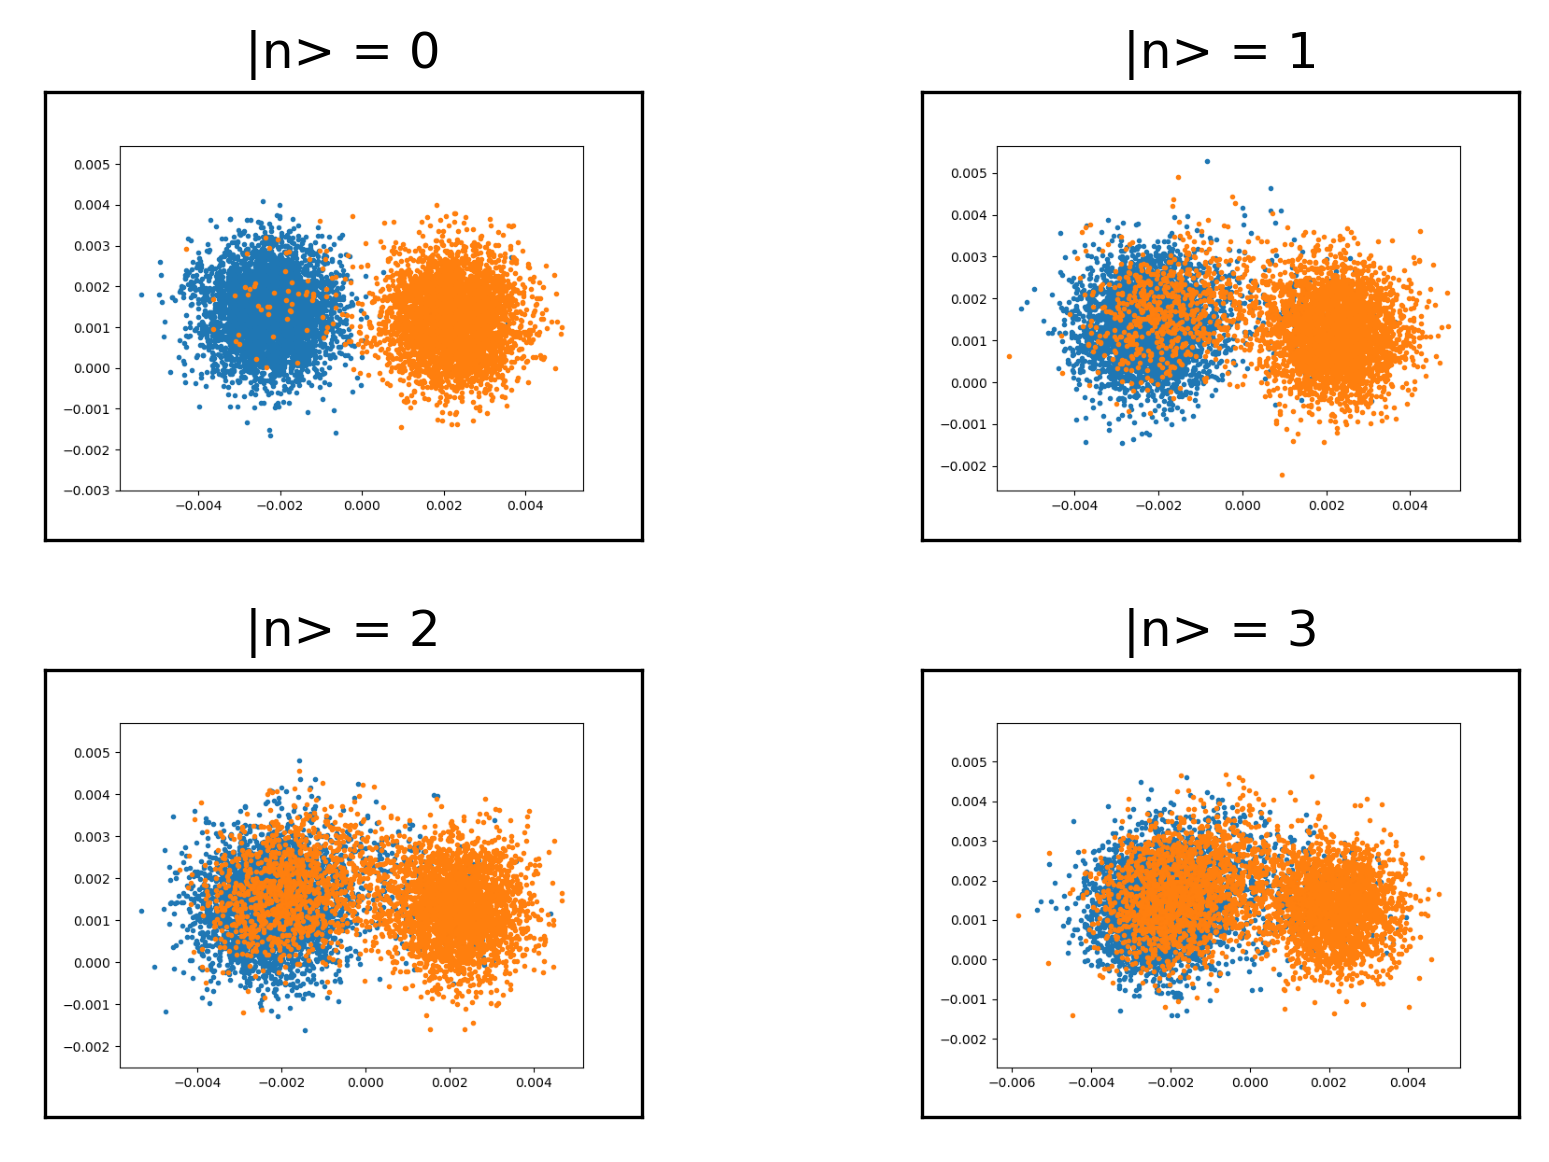

In [76]:
import matplotlib.image as mpimg

fig, axs = plt.subplots(nrows=2, ncols=2, dpi=300)
fig.tight_layout()
for ii in range(4):
    ax = axs[ii//2, ii%2]
    ax.set_title('|n> = %.f'%ii)
    img = mpimg.imread('../figures/2021-12-27-histogram-fock'+str(ii)+'-corr.png')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.imshow(img)

## Oct

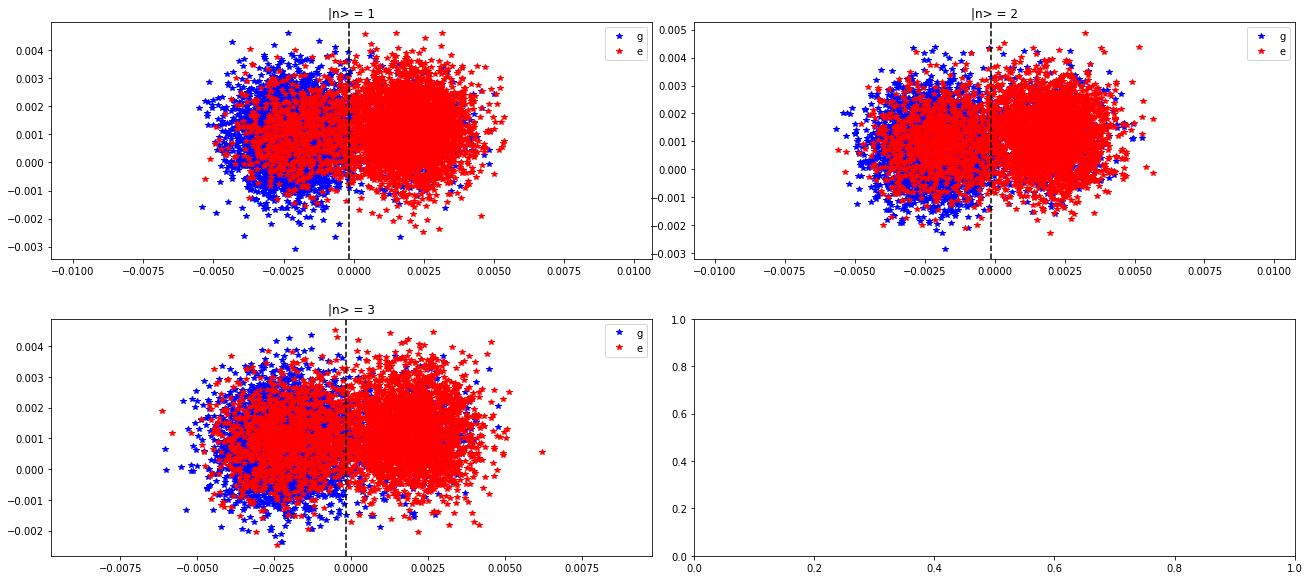

In [157]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 4*(4)//2))
fig.tight_layout()
plt.subplots_adjust(hspace=0.25)

expt_name = 'histogram_oct_fock'
filelist = [6, 7, 8]
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        fock = array(a['fock'])
        
    ax = axs[ii//2, ii%2]
    ax.set_title('|n> = %.f'%fock)
    ax.plot(Ig, Qg, 'b*', label='g')
    ax.plot(Ie, Qe, 'r*', label='e')
    ax.axvline(x=-0.00015, linestyle='--', color='k')
    ax.axis('equal')
    ax.legend(loc='best')
plt.show()

# Fock state prep using oct

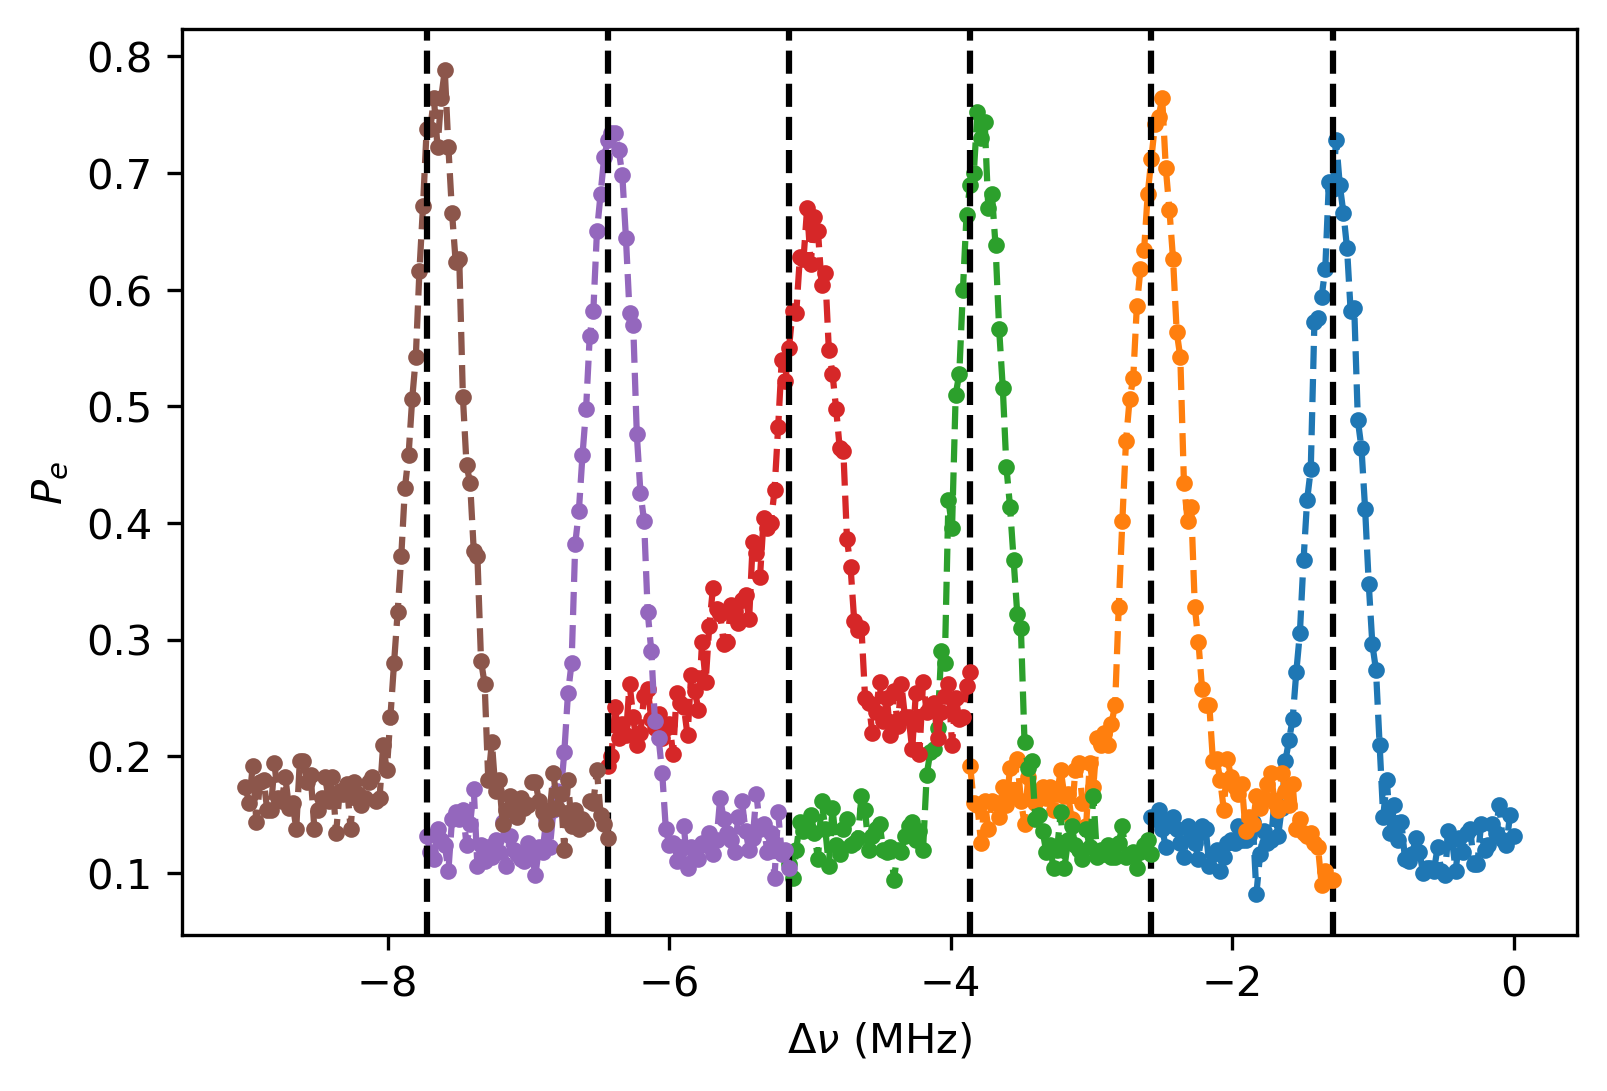

In [141]:
expt_name = 'fock_state_oct'
filelist = np.arange(1, 7, 1)
# fig, axs = plt.subplo
plt.figure(dpi=300)

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        f = array(a['freq'])-93307376
    
    plt.plot(f/1e6, Q, '.--')
    plt.xlabel(r'$\Delta \nu$ (MHz)')
    plt.axvline(x=-i*1287000/1e6, color='k', linestyle='--')
    plt.ylabel('$P_{e}$')
plt.show()